# Capability Correlations and Organizations

## 1. Data Extraction <a class="anchor" id="one"></a>

Let's start by importing all of the external libraries that will be useful during the analysis. 

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
import random

# connection to Neo4j
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

# plotly credentials
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### 1.1. Organizations in the database <a class="anchor" id="one-one"></a>

We start by creating a list of all of the organizations available in our database.

In [2]:
# query orgs
org_available_q = """     MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[:, 0]
organizations = list(raw_data)

# print an example organization
print 'Here is an example organisation: {}'.format(organizations[random.randint(1, len(organizations))])

Here is an example organisation: BIOWARME EBERNDORF


Now that we posess a list of the organizations we can start building a acapability matrix. 

The labels of the non intersecting part: 

In [3]:
q_noInter_axis = """    MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                        MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                        MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                        RETURN fs.term, pt.term, out.term, count(a)
                                """

feedstocks = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 1]).tolist()
proc_tech = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 2]).tolist()
output = np.unique(DataFrame(connection_to_graph.data(q_noInter_axis)).as_matrix()[:, 3]).tolist()

axis_names = feedstocks + proc_tech + output 
print 'The axis list has {} terms.'.format(len(axis_names))

The axis list has 289 terms.


And some extra labels from intersecting queries. 

In [4]:
q_Inter_axis = """  MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                    WHERE fs<>t 
                    RETURN fs.term, t.term, count(a)
                                    """
process_variables = ['Feedstock', 'Output', 'ProcessingTech']

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(q_Inter_axis.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in axis_names:
                axis_names.append(name)

print 'The final axis list has {} terms.'.format(len(axis_names))                

The final axis list has 342 terms.


We create a function that given a certain organization, will return its capability matrix. 

In [5]:
def get_org_matrix(org, normalization=True):
    
    # define queries
    q1 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                WHERE a.owner = "{}"
                RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(org)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    q2 = """   MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                WHERE fs<>t AND a.owner = "{}"
                RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_q1 = DataFrame(connection_to_graph.data(q1)).as_matrix()
    
    # create matrix
    org_matrix = np.zeros([len(axis_names), len(axis_names)])
    
    # for no intersections data
    for row in data_q1:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position not inter
        for pair in itertools.combinations(indexes, 2):
            org_matrix[pair[0], pair[1]] += frequency
            org_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(q2.format(category, category, org))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position inter
            for pair in itertools.combinations(indexes, 2):
                org_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                org_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    norm_org_matrix = (org_matrix - np.mean(org_matrix)) / np.std(org_matrix)
    
    # dynamic return 
    if normalization == True:
        return norm_org_matrix
    else: 
        return org_matrix

We finally test our function with the Technical University of Denmark. 

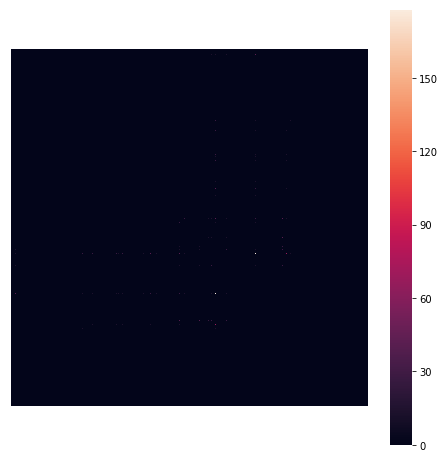

The maximum value of the TECH UNIV DENMARK matrix is in position (196, 234) with value 177.713106825 and concerns biogas and  anaerobic digestion.


In [6]:
organization = 'TECH UNIV DENMARK'
dtu_matrix = get_org_matrix(organization)

plt.subplots(1,1,figsize=(8, 8))
plt.subplot(111)
sns.heatmap(dtu_matrix, cbar=True, square=True, yticklabels=False, xticklabels=False)
plt.show()


i,j = np.unravel_index(dtu_matrix.argmax(), dtu_matrix.shape)
print 'The maximum value of the {} matrix is in position {} with value {} and concerns {} and {}.'.format(organization, (i, j), dtu_matrix[i,j], axis_names[i], axis_names[j])

In order to analyse the correlation of the orgnizations between themselves, we will need to transform each orgnization matrix into a list. Since the matrix is symmetrical, we will only need the upper triangle. For programming reasons, we have designed our own upper triangulization matrix. 

In [7]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

# example
# a = np.array([[1,2,3, 4],[4,5,6, 34],[7,8,9, 45],[10,11,12, 89]])
# print a
# print get_list_from(a)

Let's visualize the correlation between two years and their capability arrays. 

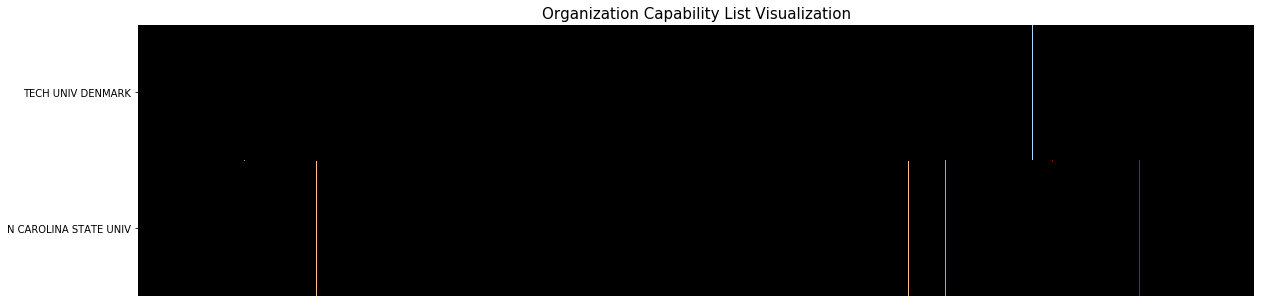

The pearson correlation index between the two organizations is: 0.137443942004 (P-value of 8.00766983664e-244)


In [8]:
# apply functions to both organizations
org_1 = 'TECH UNIV DENMARK'
org_2 = 'N CAROLINA STATE UNIV'
org_1_list = get_list_from(get_org_matrix(org_1, normalization=True))
org_2_list = get_list_from(get_org_matrix(org_2, normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((org_1_list, org_2_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=[org_1, org_2], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Organization Capability List Visualization', size=15)
plt.show()

print 'The pearson correlation index between the two organizations is: {} (P-value of {})'.format(stats.pearsonr(org_1_list, org_2_list)[0], stats.pearsonr(org_1_list, org_2_list)[1])

In our database, the number of organizations is very important. More specifically, a total of 10638. However, if we query for the organizations that only have more than 6 technological assets, the number goes down to 144. Therefore, we will limit the number of organizations depending on the number of technological assets 


In [9]:
# to do: 
# define threshold for organizations (should be about 100)
# save the lists of capability to file using np.save
# build the matrix 
# buld the cluster plot


In [19]:
# query orgs
assetLimit = 6
org_available_q = """     MATCH (n:Asset)
                            WITH n.owner as ORG
                            RETURN ORG, count(ORG)
                            ORDER BY count(ORG) DESC"""

# create a list with the years where records exist from 1 to remove null
raw_data = DataFrame(connection_to_graph.data(org_available_q)).as_matrix()[1::] 
list_of_organizations = []
for row in raw_data:
    if row[1] >= assetLimit:
        list_of_organizations.append(row[0])
        
print 'The list of organizations now has {} organizations.'.format(len(list_of_organizations))

The list of organizations now has 143 organizations.


We now create a ditionnary to store the capabilities of every organization. 

In [25]:
# create dictionnary
org_capability_dict = {}

for index, organization in enumerate(list_of_organizations):
    print 'Processing organization {} / {} \r'.format(index, len(list_of_organizations)),
    data = get_list_from(get_org_matrix(organization.encode('utf-8').strip()))
    org_capability_dict[organization] = data
    
np.save('Data/org_dict.npy', org_capability_dict)

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



We now create the matrix of correlation of organizations. 

In [28]:
numberOfOrganizations = len(list_of_organizations)
orgCapabilityMatrix = np.zeros((numberOfOrganizations, numberOfOrganizations))
org_capability_dict = np.load('Data/org_dict.npy').item()

for i in range(numberOfOrganizations):
    print 'Processing organization {} / {} \r'.format(i + 1, numberOfOrganizations),
    org_1_data = org_capability_dict[list_of_organizations[i]]
    for j in range(numberOfOrganizations):
        org_2_data = org_capability_dict[list_of_organizations[j]]
        
        orgCapabilityMatrix[i, j] = stats.pearsonr(org_1_data, org_2_data)[0]
        
np.save('Data/org_matrix.npy', orgCapabilityMatrix)

We print the heatmap. 

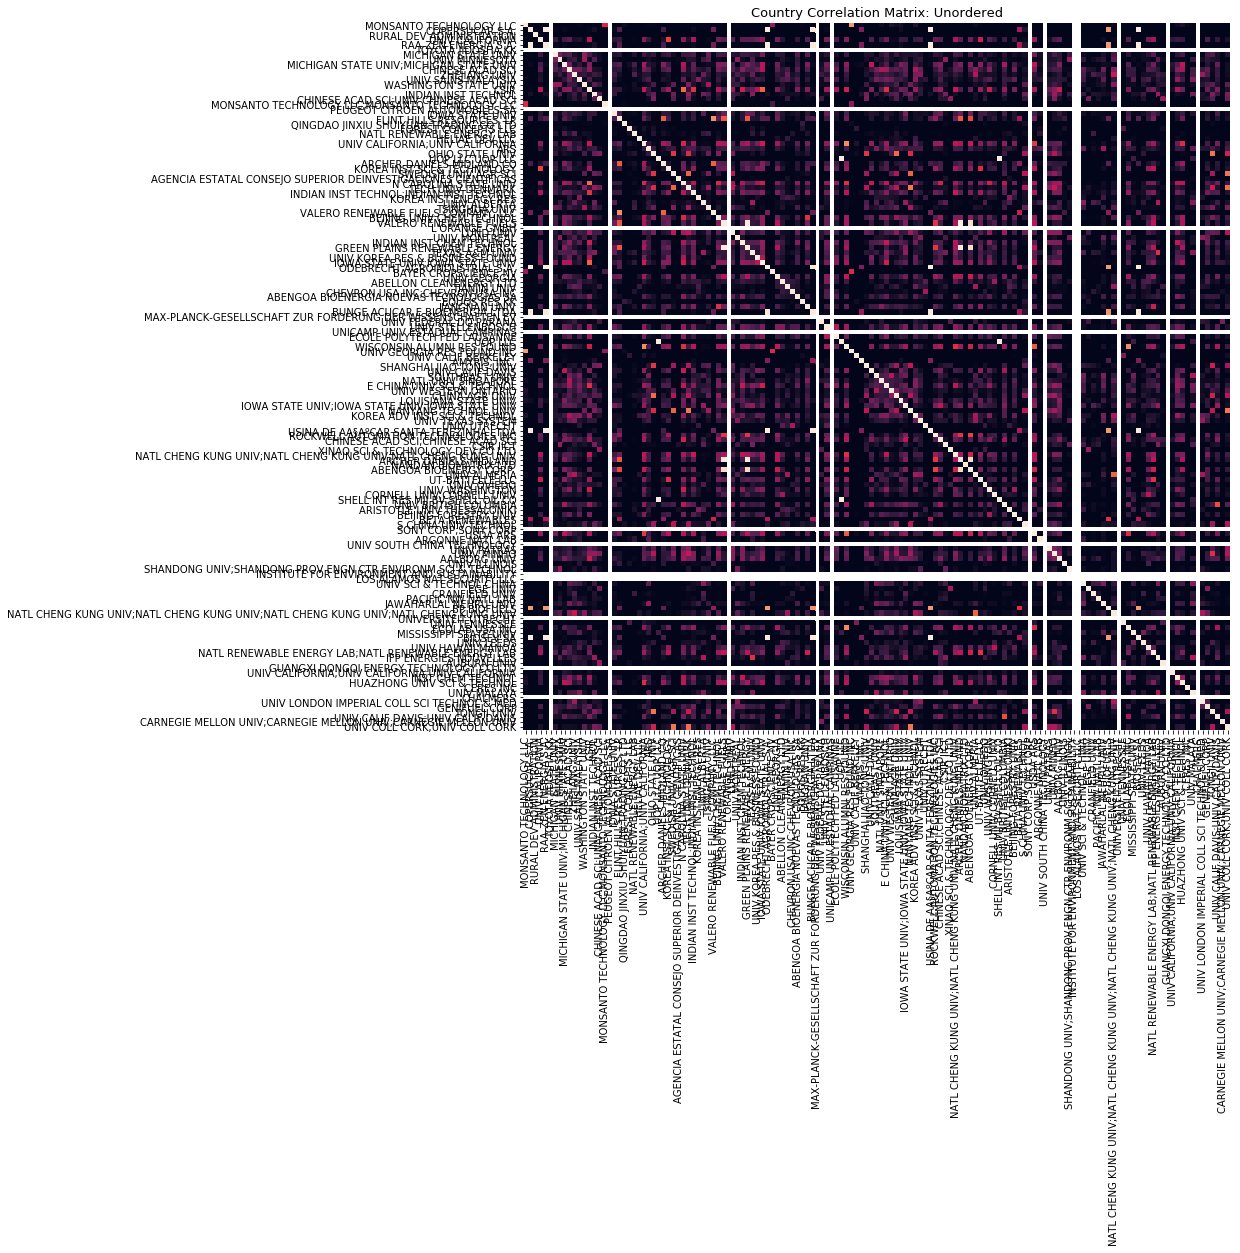

In [34]:
orgCapabilityMatrix = np.load('Data/org_matrix.npy')
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(orgCapabilityMatrix, cbar=None, square=True, yticklabels=list_of_organizations, xticklabels=list_of_organizations)
plt.title('Country Correlation Matrix: Unordered', size=13)
plt.show()

In [36]:
list_of_organizations[5]

u'TOYOTA JIDOSHA KK'

In [40]:
sum(get_org_matrix('TOYOTA JIDOSHA KK', normalization=False))

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [41]:
# PROBLEM:

#MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
#MATCH (a:Asset)-[:CONTAINS]->(out:Output)
#MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
#WHERE a.owner = "TOYOTA JIDOSHA KK"	
#RETURN fs.term, pt.term, out.term, count(a)
#
#returns no assets....